`1` Takes (pickup signals, coil currents, p-profile) --> poloidal flux map --> Classification of limiter or diverted and identification of LCFS


In [1]:
!hostname
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('CPU')))

MacBook-Pro-2.local
Num GPUs Available:  1


In [2]:
from plot_ITER_geo import get_limiter, get_vacuum_vessel

In [3]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"   
import random

import numpy as np
import pandas as pd
from numpy import matlib as mb
import matplotlib.pyplot as plt
import scipy.io

import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

print("TensorFlow version: ", tf.__version__)

from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.metrics import (r2_score, f1_score, accuracy_score, 
                             roc_curve, roc_auc_score, mean_squared_error)

import scipy.interpolate as interp
from scipy import interpolate, signal
import scipy.ndimage
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
#import mat73

from plot_ITER_geo import get_limiter, get_vacuum_vessel


TensorFlow version:  2.18.0


In [4]:

filename='/Users/aprilren/Downloads/UROP/ITER_like_equilibrium_dataset.mat'
mat = scipy.io.loadmat(filename)
for key,val in mat.items():
    print(key)
    exec(key + '=val')

__header__
__version__
__globals__
DB_meas_Bpickup_test_ConvNet
DB_psi_pixel_test_ConvNet
DB_res_RHS_pixel_test_ConvNet
DB_Jpla_pixel_test_ConvNet
DB_coils_curr_test_ConvNet
RR_pixels
ZZ_pixels
DB_separatrix_200_test_ConvNet
XP_YN
DB_f_test_ConvNet
DB_p_test_ConvNet


In [5]:
DTYPE = 'float32'

DB_meas_Bpickup_test_ConvNet = mat['DB_meas_Bpickup_test_ConvNet'].astype(DTYPE)
DB_coils_curr_test_ConvNet   = mat['DB_coils_curr_test_ConvNet'].astype(DTYPE)
DB_p_test_ConvNet            = mat['DB_p_test_ConvNet'].astype(DTYPE)
DB_f_test_ConvNet            = mat['DB_f_test_ConvNet'].astype(DTYPE)
res_RHS_pixel_data_load      = mat['DB_res_RHS_pixel_test_ConvNet'].astype(DTYPE)

RR_pixels                    = mat['RR_pixels'].astype(DTYPE)
ZZ_pixels                    = mat['ZZ_pixels'].astype(DTYPE)

DB_res_RHS_pixel_test_ConvNet   = mat['DB_res_RHS_pixel_test_ConvNet'].astype(DTYPE)
DB_separatrix_200_test_ConvNet  = mat['DB_separatrix_200_test_ConvNet'].astype(DTYPE)
XP_YN                           = mat["XP_YN"]                    # optional (diverted vs limiter)

DB_psi_pixel_test_ConvNet    = mat['DB_psi_pixel_test_ConvNet'].astype(DTYPE)
DB_Jpla_pixel_test_ConvNet   = mat['DB_Jpla_pixel_test_ConvNet'].astype(DTYPE)

print("DB_meas_Bpickup_test_ConvNet shape:", DB_meas_Bpickup_test_ConvNet.shape)
print("DB_coils_curr_test_ConvNet shape:   ", DB_coils_curr_test_ConvNet.shape)
print("DB_p_test_ConvNet shape:            ", DB_p_test_ConvNet.shape)
print("DB_f_test_ConvNet shape:            ", DB_f_test_ConvNet.shape)
print("DB_psi_pixel_test_ConvNet shape:    ", DB_psi_pixel_test_ConvNet.shape)
print("RR_pixels shape:                    ", RR_pixels.shape)
print("ZZ_pixels shape:                    ", ZZ_pixels.shape)
print("XP_YN shape:                        ", XP_YN.shape)
print("DB_separatrix_200_test_ConvNet shape:", DB_separatrix_200_test_ConvNet.shape)
print("res_RHS_pixel_data_load shape:      ", res_RHS_pixel_data_load.shape)

DB_meas_Bpickup_test_ConvNet shape: (81986, 187)
DB_coils_curr_test_ConvNet shape:    (81986, 14)
DB_p_test_ConvNet shape:             (81986, 101)
DB_f_test_ConvNet shape:             (81986, 101)
DB_psi_pixel_test_ConvNet shape:     (81986, 64, 64)
RR_pixels shape:                     (64, 64)
ZZ_pixels shape:                     (64, 64)
XP_YN shape:                         (1, 81986)
DB_separatrix_200_test_ConvNet shape: (81986, 200, 2)
res_RHS_pixel_data_load shape:       (81986, 64, 64)


69557


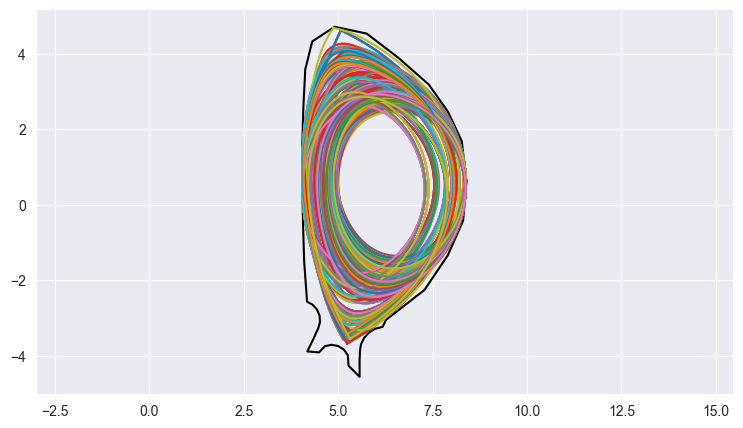

In [6]:
fw = get_limiter()
plt.figure(figsize=(9, 5))
ind_plot = np.random.randint(0,DB_Jpla_pixel_test_ConvNet.shape[0],1)[0]
print(ind_plot)
plt.plot(fw[:, 0], fw[:, 1], 'k')

for i in range(1,1000):
    plt.plot(DB_separatrix_200_test_ConvNet[i,:,0],DB_separatrix_200_test_ConvNet[i,:,1])
    plt.axis('equal')
plt.show()

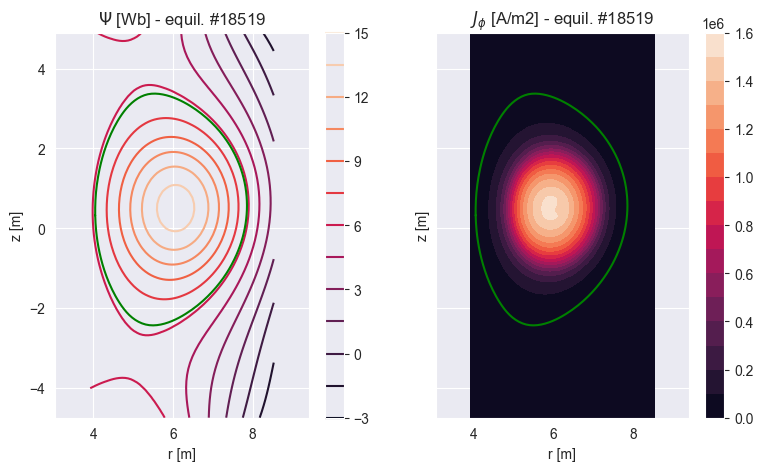

In [7]:
for i in range(0,1):
    ind_plot = np.random.randint(0,DB_Jpla_pixel_test_ConvNet.shape[0],1)[0]
    fig, axs = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
    img = axs[0].contour(RR_pixels,ZZ_pixels,DB_psi_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[0].plot(
        DB_separatrix_200_test_ConvNet[ind_plot,:,0],
        DB_separatrix_200_test_ConvNet[ind_plot,:,1],
        c='g')
    axs[0].axis('equal')
    axs[0].set_xlabel('r [m]')
    axs[0].set_ylabel('z [m]')
    axs[0].set_title('$\Psi$ [Wb] - equil. #{}'.format(ind_plot))
    img = axs[1].contourf(RR_pixels,ZZ_pixels,DB_Jpla_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[1].axis('equal')
    axs[1].set_title('$J_\phi$ [A/m2] - equil. #{}'.format(ind_plot))
    axs[1].set_xlabel('r [m]')
    axs[1].set_ylabel('z [m]')
    axs[1].plot(
        DB_separatrix_200_test_ConvNet[ind_plot,:,0],
        DB_separatrix_200_test_ConvNet[ind_plot,:,1],
        c='g')




In [ ]:
#[B_pickup signals, coil currents, p-profile]
X_data = np.column_stack([
    DB_meas_Bpickup_test_ConvNet,
    DB_coils_curr_test_ConvNet,
    DB_p_test_ConvNet,
    #DB_f_test_ConvNet
])

# The target: 2D poloidal flux map for each sample
y_data = DB_psi_pixel_test_ConvNet  # shape: (num_samples, nR, nZ)

In [9]:
num_samples = X_data.shape[0]
indices = np.arange(num_samples)

id_train, id_test = train_test_split(indices, test_size=0.35, random_state=42)

X_train = X_data[id_train, :]
X_test  = X_data[id_test, :]

y_train = y_data[id_train, :, :]
y_test  = y_data[id_test, :, :]


In [10]:
def apply_laplacian(psi):
    """
    Applies a 2D Laplacian to each (nR, nZ) flux map using TensorFlow to compute ∆ψ
    Input shape: (batch, nR, nZ)
    Output shape: (batch, nR, nZ)
    """
    psi = tf.convert_to_tensor(psi, dtype=tf.float32) # 2D flux map
    # y shape: (num_samples, nR, nZ)
    psi = tf.expand_dims(psi, axis=-1) # reshape because so output is (batch, nR, nZ, 1)

    # 2D convolution discrete version of Laplacian kernel sourced from online:
    laplacian_kernel = tf.constant([
        [0.,  1., 0.],
        [1., -4., 1.],
        [0.,  1., 0.]
    ], dtype=tf.float32)
    laplacian_kernel = tf.reshape(laplacian_kernel, [3, 3, 1, 1])

    # convolution
    delta_psi = tf.nn.conv2d(psi, laplacian_kernel, strides=[1, 1, 1, 1], padding='SAME')

    # remove the last dimension to return to original shape
    return tf.squeeze(delta_psi, axis=-1)

def loss_function_29(y, y_pred):
    """
    Computes eq. 29: L^*_Δ(ψ, ψ^p) = (1/M) * Σ (Δ*ψ - Δ*ψ^p)^2
    """
    delta_psi = apply_laplacian(y)
    delta_psi_pred = apply_laplacian(y_pred)
    return tf.reduce_mean(tf.square(delta_psi - delta_psi_pred))

def hybrid_loss(y_true, y_pred, λ=1.0):
    lap_true = apply_laplacian(y_true)
    lap_pred = apply_laplacian(y_pred)
    lap_loss = tf.reduce_mean(tf.square(lap_true - lap_pred))
    l2_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return lap_loss + λ * l2_loss

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [13]:
n_r = y_train.shape[1]  # number of radial points
n_z = y_train.shape[2]  # number of vertical points
out_size = n_r * n_z    # flatten the 2D flux map

from tensorflow.keras import backend as K
K.clear_session()  
np.random.seed(42)
tf.random.set_seed(42)  

def build_dense_model(input_dim, output_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(output_dim, activation='linear')(x) # added dense layer to output flat vector
    outputs = layers.Reshape((n_r, n_z))(x) # reshaped output layer
    # outputs = layers.Dense(output_dim, activation='linear')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=lambda y, y_pred: hybrid_loss(y, y_pred, λ=1.0))
    return model

model = build_dense_model(input_dim=X_train.shape[1], output_dim=out_size)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 403)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        51,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 613,120 (2.34 MB)

 Trainable params: 613,120 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# y_train_flat = y_train.reshape(y_train.shape[0], -1)  # shape: (N, nR*nZ)
# y_test_flat  = y_test.reshape(y_test.shape[0], -1)

# history = model.fit(X_train, y_train_flat,
                    # validation_data=(X_test, y_test_flat),
                    # epochs=50, batch_size=32, verbose=1)
import numpy as np, tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='checkpoints/model_epoch_{epoch:02d}.weights.h5',  # custom name per epoch
    save_weights_only=True,  save_freq='epoch', verbose=1)

history = model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), callbacks=[checkpoint_cb])

Epoch 1/300
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.8220
Epoch 1: saving model to checkpoints/model_epoch_01.weights.h5
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - loss: 7.8186 - val_loss: 0.2171
Epoch 2/300
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1510
Epoch 2: saving model to checkpoints/model_epoch_02.weights.h5
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.1510 - val_loss: 0.2573
Epoch 3/300
1663/1666 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0882
Epoch 3: saving model to checkpoints/model_epoch_03.weights.h5
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - loss: 0.0882 - val_loss: 0.1144
Epoch 4/300
1661/1666 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0656
Epoch 4: saving model to checkpoints/model_epoch_04.weights.h5
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0657 - val_loss: 0.1143
Epoch 5/300
1660/1666 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0543
Epoch 5: saving model to checkpoints/model_epoch_05.weights.h5
1666/1666 ━━━━━━━

In [15]:
import json

# with open('checkpoints/history_laplacian.json', 'w') as f:
#     json.dump(history.history, f)

save_path = os.path.expanduser("./history_laplacian.json") 

with open(save_path, 'w') as f:
    json.dump(history.history, f)

print(f"Saved history to {save_path}")



Saved history to ./history_laplacian.json


In [ ]:
import json

with open('./history_laplacian.json', 'r') as f:
   history = json.load(f)

#from tensorflow.keras.models import load_model
#model = build_dense_model(input_dim=X_train.shape[1], output_dim=out_size) 
#model.load_weights("checkpoints/model_epoch_100.weights.h5")

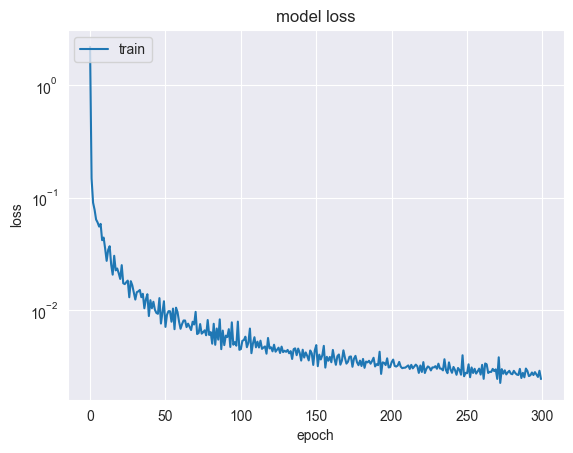

In [16]:
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
y_pred = model.predict(X_test)
rel_error = np.linalg.norm(y_pred.reshape(y_test.shape[0], -1) - 
                           y_test.reshape(y_test.shape[0], -1), axis=1) / \
            np.linalg.norm(y_test.reshape(y_test.shape[0], -1), axis=1)

print("Mean relative error:", np.mean(rel_error))

897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step
Mean relative error: 0.0076895356


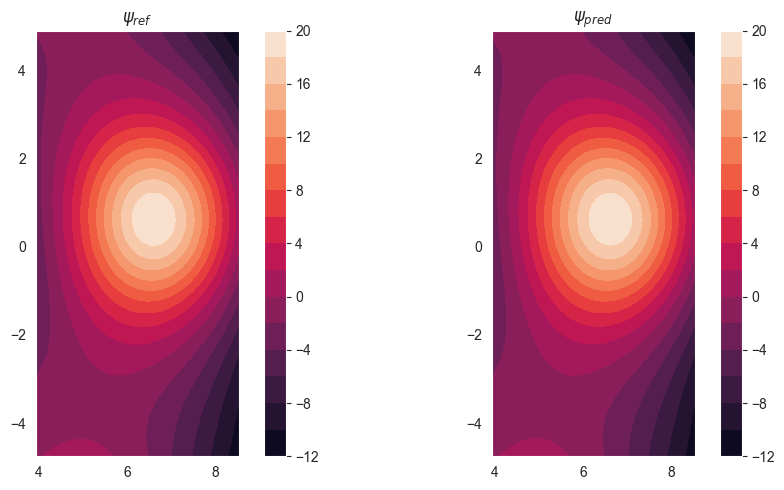

In [19]:
i = random.randint(0, len(id_test)-1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot reference psi
cs0 = axs[0].contourf(RR_pixels, ZZ_pixels, y_test[i], 20)
axs[0].set_title(r'$\psi_{ref}$')
axs[0].set_aspect('equal')
fig.colorbar(cs0, ax=axs[0])

# Plot predicted psi
cs1 = axs[1].contourf(RR_pixels, ZZ_pixels, y_pred[i], 20)
axs[1].set_title(r'$\psi_{pred}$')
axs[1].set_aspect('equal')
fig.colorbar(cs1, ax=axs[1])

plt.tight_layout()
plt.show()

In [20]:
mse_test = np.mean((y_pred.reshape(y_test.shape[0], -1) - y_test.reshape(y_test.shape[0], -1))**2)
print(mse_test)

0.002436093


In [21]:
#Rebuild the model architecture first (same as before) 
model = build_dense_model(input_dim=X_train.shape[1], output_dim=64*64)

#Load weights from a specific checkpoint 
model.load_weights('checkpoints/model_epoch_100.weights.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
# # Flatten predictions and ground truth for train and test
y_train_pred = model.predict(X_train).reshape(y_train.shape[0], -1)
y_test_pred  = model.predict(X_test).reshape(y_test.shape[0], -1)

y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_test_flat  = y_test.reshape(y_test.shape[0], -1)

# # R^2 scores
r2_train = r2_score(y_train, y_train_pred) * 100
r2_test  = r2_score(y_test, y_test_pred) * 100

factor_subsampling = 500  
plt.figure()

# Flatten the arrays again to compare individual pixel values
plt.scatter(y_pred[0:-1:factor_subsampling].flatten(), y_train_pred[0:-1:factor_subsampling].flatten(), 1, label='train')
plt.scatter(y_test[0:-1:factor_subsampling].flatten(), y_test_pred[0:-1:factor_subsampling].flatten(), 1, label='test')
plt.axis('equal')
plt.legend()
plt.title(f'Rsquared_train = {r2_train:.2f}, Rsquared_test = {r2_test:.2f}') 
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

1666/1666 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step


KeyboardInterrupt: 

In [23]:
import json
with open('checkpoints/history_laplacian.json', 'w') as f:
    json.dump(history, f)

TypeError: Object of type History is not JSON serializable

(3.924999952316284, 8.524999618530273, -4.75, 4.900000095367432)

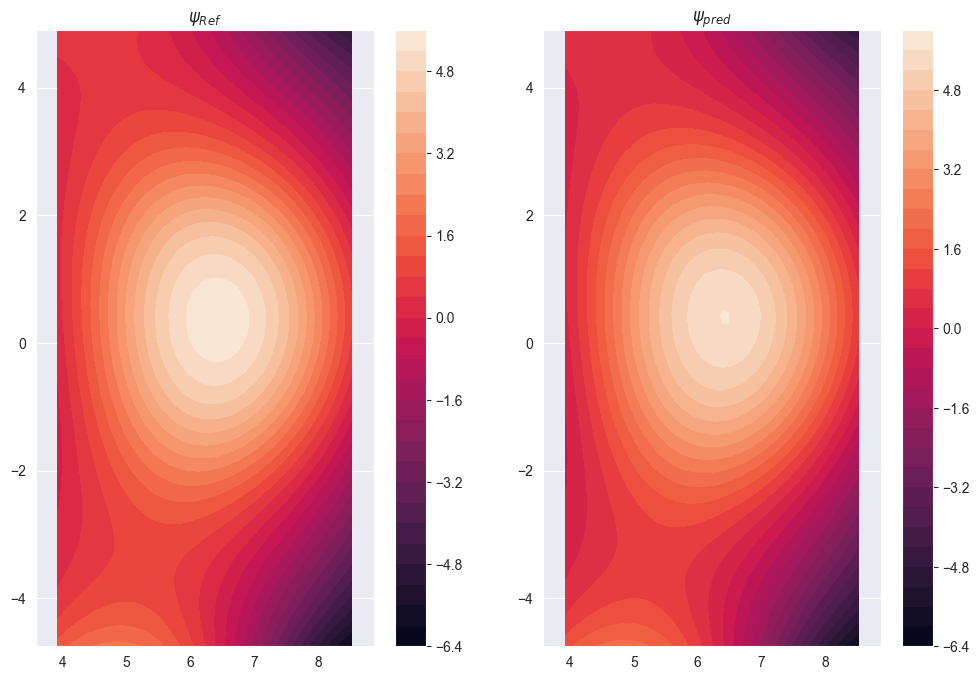

In [24]:
import random
idx = random.randint(0, len(id_test)-1)

psi_ref = y_test[idx,:,:]
psi_pred = y_pred[idx,:,:]

plt.figure(figsize=(12,8))
#plt.suptitle(f"Sample index {idx} (Test)")
plt.subplot(1,2,1)
plt.title("$\psi_{Ref}$")
plt.contourf(RR_pixels, ZZ_pixels, psi_ref, 30)
plt.colorbar()
plt.axis('equal')
plt.subplot(1,2,2)
plt.title("$\psi_{pred}$")
plt.contourf(RR_pixels, ZZ_pixels, psi_pred, 30)
plt.colorbar()
plt.axis('equal')

In [25]:
N, nR, nZ = DB_psi_pixel_test_ConvNet.shape
flux_flat = DB_psi_pixel_test_ConvNet.reshape(N, -1)  # shape: (N, nR*nZ)
XP_YN.shape

(1, 81986)

In [26]:
y_class = XP_YN.squeeze().astype(np.float32)  # shape: (N,)
y_class.shape

(81986,)

In [27]:
N_bound_pts = DB_separatrix_200_test_ConvNet.shape[1]  # 200
y_boundary = DB_separatrix_200_test_ConvNet.reshape(N, -1).astype(np.float32)  # shape: (N, 400)

yindices = np.arange(N)
id_train, id_test = train_test_split(yindices, test_size=0.3, random_state=42)
id_test.shape

(24596,)

In [28]:
X_train = flux_flat[id_train, :]  # shape: (N_train, nR*nZ)
X_test  = flux_flat[id_test, :]
y_class_train = y_class[id_train]         # shape: (N_train,)
y_class_test  = y_class[id_test]
y_bound_train = y_boundary[id_train, :]   # shape: (N_train, 400)
y_bound_test  = y_boundary[id_test, :]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
import tensorflow.keras.backend as K

def pairwise_distances(x, y):
    """
    Computes pairwise Euclidean distances of two sets of points
    """
    # x, y: shape (batch, N, 2)
    x = tf.expand_dims(x, axis=2) # (batch, N, 1, 2)
    y = tf.expand_dims(y, axis=1) # (batch, 1, M, 2)
    return tf.norm(x - y, axis=-1) # (batch, N, M)

def hausdorff_loss(y_true, y_pred):
    """
    pred_points: Tensor of shape (N, D)
    expected_points: Tensor of shape (M, D)
    Returns an approximation to Hausdorff distance (max operation is not differentiable so we take average Hausdorff distance)
    """
    # y_true, y_pred: shape (batch, 400)
    y_true = tf.reshape(y_true, (-1, 200, 2))
    y_pred = tf.reshape(y_pred, (-1, 200, 2))
    dists = pairwise_distances(y_pred, y_true) # (batch, 200, 200)

    min_pred_to_true = tf.reduce_min(dists, axis=2) # (batch, 200)
    min_true_to_pred = tf.reduce_min(dists, axis=1) # (batch, 200)
    
    forward_hd = tf.reduce_mean(min_pred_to_true, axis=1) # (batch,)
    backward_hd = tf.reduce_mean(min_true_to_pred, axis=1) # (batch,)
    
    return tf.reduce_mean(forward_hd + backward_hd)

In [29]:
def chamfer_loss(num_pts):
    """
    Returns a loss fn that takes (y_true, y_pred) and computes symmetric Chamfer
    """
    def loss(y_true, y_pred):
        pts_pred = tf.reshape(y_pred, (-1, num_pts, 2))
        pts_true = tf.reshape(y_true,  (-1, num_pts, 2))

        # pairwise distance: (batch, num_pts, num_pts)
        diff = tf.expand_dims(pts_pred, 2) - tf.expand_dims(pts_true, 1)
        dist = tf.norm(diff, axis=-1)

        # mean over pred
        cd_pred = tf.reduce_mean(tf.reduce_min(dist, axis=2), axis=1)
        # mean over true
        cd_true = tf.reduce_mean(tf.reduce_min(dist, axis=1), axis=1)

        # per‐sample symmetric Chamfer
        cd = cd_pred + cd_true
        return tf.reduce_mean(cd)
    return loss



In [30]:

def build_multi_output_model(n_input, n_boundary):
    """
    n_input: size of flattened flux (nR*nZ)
    n_boundary: total boundary coords to predict (200*2 = 400)
    """
    # inputs = layers.Input(shape=(n_input,))

    # Encoder
    inputs = layers.Input(shape=(n_input,), name="flux_input")
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(128, activation="relu")(x)
    encoded = layers.Dense(64, activation="relu", name="encoder_output")(x)

    # Classification decoder
    c = layers.Dense(32, activation="relu")(encoded)
    clas_out = layers.Dense(1, activation="sigmoid", name="classification_head")(c)

    # Boundary decoder
    b = layers.Dense(32, activation="relu")(encoded)
    bound_out = layers.Dense(n_boundary, activation="linear", name="boundary_head")(b)

    model = Model(inputs=inputs, outputs=[clas_out, bound_out], name="shared_encoder_model")

    # x = layers.Dense(128, activation='relu')(inputs)
    # x = layers.Dense(128, activation='relu')(x)
    # x = layers.Dense(64, activation='relu')(x) 
    # clas_out = layers.Dense(1, activation='sigmoid', name="classification_head")(x)
    # bound_out = layers.Dense(n_boundary, activation='linear', name="boundary_head")(x)
    # model = Model(inputs=inputs, outputs=[clas_out, bound_out])
    a1, a2 = 1.0, 0.1
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            "classification_head": "binary_crossentropy",
            "boundary_head": chamfer_loss(n_boundary // 2)
        },
        loss_weights={
           "classification_head": a1,  # added these
           "boundary_head": a2
        },
        metrics={
            "classification_head": ["accuracy"]
        }
    )

    return model


K.clear_session()

import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


n_input = X_train_scaled.shape[1]  # nR*nZ
n_boundary = y_bound_train.shape[1]  # 400
model_multi = build_multi_output_model(n_input, n_boundary)
model_multi.summary()


Model: "shared_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ flux_input          │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    524,416 │ flux_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_output      │ (None, 64)        │      8,256 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ encoder_output[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ encoder_output[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_head │ (None, 1)         │         33 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boundary_head       │ (None, 400)       │     13,200 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 566,577 (2.16 MB)

 Trainable params: 566,577 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

## Defining Loss Function
* Loss= $\alpha_{1} \|\psi_{pred} − \psi_{ref}\|^{2} + \alpha_{2} \|\Delta^{*}\psi_{pred} − \Delta^{*}\psi_{ref}\|^2$


In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = f'checkpoints/model_final_{{epoch:02d}}.weights.h5'
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

history_cl = model_multi.fit(
    X_train_scaled,
    [y_class_train, y_bound_train],
    validation_data=(
        X_test_scaled,
        [y_class_test, y_bound_test]
    ),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_cb],
    verbose=1
)

y_class_pred_train, y_bound_pred_train = model_multi.predict(X_train_scaled)
y_class_pred_test,  y_bound_pred_test  = model_multi.predict(X_test_scaled)
y_class_bin_train = (y_class_pred_train > 0.5).astype(int).ravel()
y_class_bin_test  = (y_class_pred_test  > 0.5).astype(int).ravel()
acc_train = accuracy_score(y_class_train, y_class_bin_train)
acc_test  = accuracy_score(y_class_test,  y_class_bin_test)

f1_train  = f1_score(y_class_train, y_class_bin_train)
f1_test   = f1_score(y_class_test,  y_class_bin_test)

print(f"Classification - TRAIN: Acc={acc_train:.3f}, F1={f1_train:.3f}")
print(f"Classification - TEST:  Acc={acc_test:.3f},  F1={f1_test:.3f}")

Epoch 1/100
1791/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - boundary_head_loss: 1.7614 - classification_head_accuracy: 0.8768 - classification_head_loss: 0.3090 - loss: 0.4851
Epoch 1: saving model to checkpoints/model_final_01.weights.h5
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - boundary_head_loss: 1.7599 - classification_head_accuracy: 0.8769 - classification_head_loss: 0.3088 - loss: 0.4848 - val_boundary_head_loss: 0.6786 - val_classification_head_accuracy: 0.9121 - val_classification_head_loss: 0.1645 - val_loss: 0.2324
Epoch 2/100
1792/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - boundary_head_loss: 0.6884 - classification_head_accuracy: 0.9365 - classification_head_loss: 0.1495 - loss: 0.2183
Epoch 2: saving model to checkpoints/model_final_02.weights.h5
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - boundary_head_loss: 0.6882 - classification_head_accuracy: 0.9365 - classification_head_loss: 0.1495 - loss: 0.2183 - val_boundary_head_loss: 0.4801 - val_classification_head_accurac

In [32]:
# history_file = f'checkpoints/history.json'
# with open(history_file, 'w') as f:
#     json.dump(history_cl, f)
import json
save_path = os.path.expanduser("./history.json") 

with open(save_path, 'w') as f:
    json.dump(history_cl.history, f)

print(f"Saved history to {save_path}")

Saved history to ./history.json


In [33]:
y_bound_train_flat = y_bound_train.reshape(-1)
y_bound_pred_train_flat = y_bound_pred_train.reshape(-1)

r2_bound_train = r2_score(y_bound_train_flat, y_bound_pred_train_flat)

y_bound_test_flat = y_bound_test.reshape(-1)
y_bound_pred_test_flat = y_bound_pred_test.reshape(-1)
r2_bound_test  = r2_score(y_bound_test_flat, y_bound_pred_test_flat)
print(f"Boundary R² - TRAIN: {r2_bound_train:.4f}, TEST: {r2_bound_test:.4f}")


Boundary R² - TRAIN: 0.5332, TEST: 0.5327


In [34]:
# prediction error 
# subtract between contours, check difference between two counters

from scipy.spatial import cKDTree, distance
from shapely.geometry import Polygon

def compute_lcfs_errors(true_lcfs_list, pred_lcfs_list):
    avg_distances = []
    hausdorff_distances = []
    area_errors = []

    for true_pts, pred_pts in zip(true_lcfs_list, pred_lcfs_list):
        # Average point-wise distance (bidirectional)
        tree_true = cKDTree(true_pts)
        tree_pred = cKDTree(pred_pts)

        dists1, _ = tree_true.query(pred_pts)
        dists2, _ = tree_pred.query(true_pts)

        avg_dist = (np.mean(dists1) + np.mean(dists2)) / 2
        avg_distances.append(avg_dist)

        # Hausdorff distance
        hd1 = distance.directed_hausdorff(true_pts, pred_pts)[0]
        hd2 = distance.directed_hausdorff(pred_pts, true_pts)[0]
        hausdorff_distances.append(max(hd1, hd2))

        # Area difference
        try:
            poly_true = Polygon(true_pts)
            poly_pred = Polygon(pred_pts)
            area_error = poly_true.symmetric_difference(poly_pred).area
        except:
            area_error = np.nan  # In case the polygon is invalid
        area_errors.append(area_error)

    return {
        "avg_pointwise_distance": np.array(avg_distances),
        "hausdorff_distance": np.array(hausdorff_distances),
        "area_difference": np.array(area_errors),
    }

In [35]:
true_lcfs_list = [y_bound_test[i].reshape(-1, 2) for i in range(len(y_bound_test))]
pred_lcfs_list = [y_bound_pred_test[i].reshape(-1, 2) for i in range(len(y_bound_pred_test))]

In [ ]:
errors = compute_lcfs_errors(true_lcfs_list, pred_lcfs_list)
plt.hist(errors["avg_pointwise_distance"], bins=30, alpha=0.6, label='Avg Distance')
plt.hist(errors["hausdorff_distance"], bins=30, alpha=0.6, label='Hausdorff')
plt.legend()
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("LCFS Prediction Errors")

In [ ]:
hausdorff_errors = errors["hausdorff_distance"]
worst_indices = np.argsort(hausdorff_errors)[-5:]
threshold = 3.0
bad_indices = np.where(hausdorff_errors > threshold)[0]

print(f"Number of bad samples (Hausdorff error > {threshold}): {len(bad_indices)}")

for i, idx in enumerate(worst_indices):
    true_pts = true_lcfs_list[idx]
    pred_pts = pred_lcfs_list[idx]

    plt.figure(figsize=(5, 5))
    plt.plot(true_pts[:, 0], true_pts[:, 1], 'k-', label='True LCFS')
    plt.plot(pred_pts[:, 0], pred_pts[:, 1], 'r--', label='Predicted LCFS')
    plt.title(f"Hausdorff Error = {hausdorff_errors[idx]:.3f}  (Sample #{idx})")
    plt.xlabel("R")
    plt.ylabel("Z")
    plt.axis("equal")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
sample_indices = [16365, 19751, 3552] 

for idx in sample_indices:
    psi_true_flat = X_test[idx]
    psi_true = psi_true_flat.reshape(64, 64)

    psi_pred_flat = y_pred[idx]
    psi_pred = psi_pred_flat.reshape(64, 64)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # true flux map
    axs[0].contourf(psi_true, levels=50, cmap='viridis')
    axs[0].set_title(f"True Poloidal Flux – Sample #{idx}")
    axs[0].set_xlabel("Z")
    axs[0].set_ylabel("R")

    # predicted flux map
    axs[1].contourf(psi_pred, levels=50, cmap='viridis')
    axs[1].set_title("Predicted Poloidal Flux")
    axs[1].set_xlabel("Z")
    axs[1].set_ylabel("R")

    plt.tight_layout()
    plt.colorbar(axs[0].collections[0], ax=axs, location='right', label='ψ')
    plt.show()

In [ ]:
sample_indices = [11327, 21541, 3552] 

for idx in sample_indices:
    # reshape poloidal flux map 
    psi_flat = X_test[idx]
    psi_map = psi_flat.reshape(n_r, n_z)
    
    # LCFS contours
    true_pts = true_lcfs_list[idx]
    pred_pts = pred_lcfs_list[idx]

    RR = RR_pixels
    ZZ = ZZ_pixels
    
    plt.figure(figsize=(7, 6))
    contour = plt.contourf(RR, ZZ, psi_map, levels=50, cmap='viridis')
    plt.colorbar(contour, label='ψ (poloidal flux)')
    plt.plot(true_pts[:, 0], true_pts[:, 1], 'k-', linewidth=2, label='True LCFS')
    plt.plot(pred_pts[:, 0], pred_pts[:, 1], 'r--', linewidth=2, label='Predicted LCFS')
    plt.title(f"LCFS Comparison – Sample #{idx}")
    plt.xlabel("R (m)")
    plt.ylabel("Z (m)")
    plt.axis("equal")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
for _ in range(3):
    idx = random.randint(0, len(id_test)-1)
    true_label = y_class_test[idx]
    pred_prob  = y_class_pred_test[idx][0]
    pred_label = y_class_bin_test[idx]

    print(f"Sample {idx}: True label={true_label} / Pred prob={pred_prob:.3f} / Pred label={pred_label}")

idx = random.randint(0, len(id_test)-1)
bound_true = y_bound_test[idx,:].reshape(-1,2)
bound_pred = y_bound_pred_test[idx,:].reshape(-1,2)

plt.figure(figsize=(10,8))
psi_2d = DB_psi_pixel_test_ConvNet[id_test[idx], :, :]
filled = plt.contourf(RR_pixels, ZZ_pixels, psi_2d, levels=30, cmap='viridis')
plt.colorbar(filled, label="Poloidal Flux")
lines = plt.contour(RR_pixels, ZZ_pixels, psi_2d, levels=30, colors='black', linewidths=0.5)
plt.plot(bound_true[:,0], bound_true[:,1], 'b--', label="True LCFS")
plt.plot(bound_pred[:,0], bound_pred[:,1], 'g-', label="Pred LCFS")

plt.legend(fontsize=14)
plt.axis('equal')
plt.xlabel("R [m]")
plt.ylabel("Z [m]")
plt.title(f"Poloidal Flux and LCFS – Equil #{idx}")
plt.show()

# plt.figure(figsize=(10,8))
# psi_2d = DB_psi_pixel_test_ConvNet[id_test[idx], :, :]
# plt.contour(RR_pixels, ZZ_pixels, psi_2d, 50)
# plt.colorbar(label="Poloidal Flux")
# plt.plot(bound_true[:,0], bound_true[:,1], 'b--', label="True LCFS")
# plt.plot(bound_pred[:,0], bound_pred[:,1], 'g-', markersize=2, label="Pred LCFS")
# plt.legend(fontsize=18)
# plt.axis('equal')
# plt.show()

In [ ]:
DB_meas_Bpickup_test_ConvNet[0,:].shape

In [ ]:
train_loss = history['loss']
val_loss = history['val_loss']

# Plot loss vs epochs
plt.figure(figsize=(8, 5))
plt.semilogy(train_loss, label='Training Loss')
plt.semilogy(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def compute_GS_operator(psi, RR, ZZ):
    """
    psi shape: (batch, nR, nZ)
    RR, ZZ shape: (nR, nZ) - same for all batch
    Returns: gs_op shape (batch, nR, nZ)
    """
    # naive center-diff. ignoring edges
    # We'll do it in numpy for clarity; for a TF-based approach, we could use tf.nn.conv2d
    
    # We assume psi, RR, ZZ are np arrays for the moment (custom loop).
    # If you want it purely in TF, you'll define a tf function using convolutions.
    
    batch_size = psi.shape[0]
    nR, nZ = psi.shape[1], psi.shape[2]
    gs_op = np.zeros_like(psi)
    
    dR = RR[1,0] - RR[0,0]
    dZ = ZZ[0,1] - ZZ[0,0] if nZ>1 else 1e-3  # you must adapt if your grid is different

    for b in range(batch_size):
        psi_b = psi[b,:,:]
        # Laplacian
        lap = (
            np.roll(psi_b, 1, axis=0) - 2*psi_b + np.roll(psi_b, -1, axis=0)
        )/(dR**2) + (
            np.roll(psi_b, 1, axis=1) - 2*psi_b + np.roll(psi_b, -1, axis=1)
        )/(dZ**2)

        # - (1/R)* d(psi)/dR
        # R is function of row index => R[i,:]
        R_1d = RR[:,0]  # shape (nR,)
        dpsi_dR = (
            np.roll(psi_b, -1, axis=0) - np.roll(psi_b, 1, axis=0)
        )/(2*dR)
        
        # broadcast R to shape (nR, nZ)
        R_2d = np.tile(R_1d.reshape(-1,1), (1,nZ))
        out = lap - (1.0/R_2d)*dpsi_dR
        gs_op[b,:,:] = out

    return gs_op
